# Content

This notebook processes CSV files summarizing inferred selection coefficients and creates the necessary files to reproduce the figures shown in the article. Additionally, it generates figures corresponding to those in the paper.

In [6]:
#Pkg.add("Pkg"); import Pkg; 
ENV["LD_LIBRARY_PATH"] = ""
using Pkg
using Distributed
using DelimitedFiles
using Distances
using StatsBase  # StatsBase.mode
using CSV
using Profile    
using Random
using Statistics
using LinearAlgebra
using KernelDensity
using Printf
using Measures
using LaTeXStrings;
using Plots
using DataFrames
using StatsPlots
rng = Random.MersenneTwister(1234);

Plots.default(grid =:false, fontfamily="Computer Modern", 
labelfontsize=12, tickfontsize=12, legendfontsize=12, markerstrokewidth=0, ms=5, 
foreground_color_legend = nothing);

In [19]:
include("../src/HIV_data_claning.jl")
include("../src/figure.jl");
include("../src/process_HIV_mutation_for_CSV.jl"); # load extract_integer

In [8]:
const pxl2pt = 0.75;
α_gen_dbl = 83 * 0.5
α_gen_sgl = 83
α_lbl_dbl = 55.4 * 0.5
α_lbl_sgl = 55.4;
my_margin = 5mm;

In [9]:


Alpha_set_temp = ["-","A","C","D","E","F","G","H","I","K","L","M","N","P","Q","R","S","T","V","W","Y", "*"];
Alpha_Dic_temp = Dict( "-"=>1,"A"=>2,"C"=>3,"D"=>4,"E"=>5,
	"F"=>6,"G"=>7,"H"=>8,"I"=>9,"K"=>10,"L"=>11,
	"M"=>12,"N"=>13,"P"=>14,"Q"=>15,"R"=>16,"S"=>17,"T"=>18,"V"=>19,"W"=>20, "Y"=>21, "*"=>22);
NUC = ["-", "A", "C", "G", "T"];
q = length(NUC);
AA_set = ["-", "A", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N", "P", "Q", "R", "S", "T", "V", "W", "Y", "*"];
AA2NUM = Dict(AA_set[i] => i for i in 1:length(AA_set));
q_AA = length(AA_set);

In [10]:
fname_key_human_and_RMs = ["703010505", "RM5695", "RM6070", "RM6072", "RM6697", "RM6699", "RM6701", "RM6703"];
n_RMs_max = length(fname_key_human_and_RMs)
n_len_H_RMs = length(fname_key_human_and_RMs);
csv_raw_CH505 = DataFrame(CSV.File("../out/703010505-3-poly_sorted_with_mutant.csv"));
csv_raw_RMs_merged = DataFrame(CSV.File("../out/RMs-merged-3-poly_sorted_with_mutant_CH505.csv"));

seq_raw = readdlm("../data/mpl/703010505-3-poly-seq2state.dat");
time_temp = copy(seq_raw[:,1])
time_unique = Int.(sort(unique(time_temp)));

In [11]:

#count(csv_raw_CH505.nonsynonymous .== 0)
count(csv_raw_CH505.nonsynonymous[csv_raw_CH505.reversion] .> 0)

129

In [12]:
count(csv_raw_CH505.nonsynonymous[csv_raw_CH505.reversion] .== 0)

29

## Making Trajecotry plots 

In [20]:
L_fig_tot = 1_200
idx_CTL = [extract_integer(x) ∈ 409:418 for x in csv_raw_CH505.mutants_AA_fr3 ]
(plot_traject, time_unique, x1_CTL, x1_CH103, x1_CH235, x1_autologous, x1_glycan) = get_trajectory_plot_CH505_with_glycan(csv_raw_CH505, L_fig_tot);

(plot_selection_vs_time, time_CTL, time_CH103, time_CH235, time_autologous, time_glycan, 
selection_CTL, selection_CH103, selection_CH235, selection_autologous, selection_glycan, 
name_mutation_CTL, name_mutation_CH103, name_mutation_CH235, name_mutation_strain_specific, name_mutation_glycan) = get_selection_vs_time_plot_CH505_with_glycan(csv_raw_CH505, L_fig_tot);

(plot_violin_plot, s_res_CH103, s_res_CH235, s_res_spcfc, s_res_glycan, s_res_CTL) = get_violin_plot_CH505_with_glycan(csv_raw_CH505, L_fig_tot);

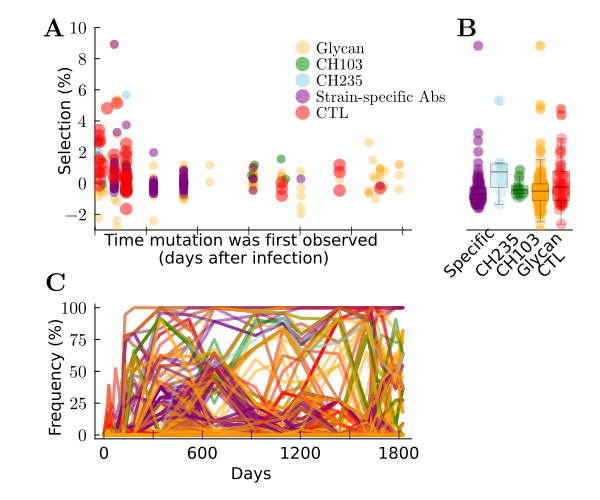

In [21]:
l = @layout [
    a{0.75w, 0.6h} b{0.25w, 0.6h}
    c{0.75w, 0.4h} _]
Plots.plot(plot_selection_vs_time, plot_violin_plot, 
            plot_traject, layout=l, size=(L_fig_tot*0.5,500))
#Plots.savefig("../fig/trajecory_selection_CH505.pdf")

In [22]:
flat_x1_CTL = [item for sublist in x1_CTL for item in sublist]
flat_time_CTL = [item for sublist in x1_CTL for item in time_unique]
flat_id_CTL = [@sprintf("CTL.%d", n) for n in 1:size(x1_CTL,1) for i in time_unique]
#
flat_x1_CH103 = [item for sublist in x1_CH103 for item in sublist]
flat_time_CH103 = [item for sublist in x1_CH103 for item in time_unique]
flat_id_CH103 = [@sprintf("CH103.%d", n) for n in 1:size(x1_CH103,1) for i in time_unique]
#
flat_x1_CH235 = [item for sublist in x1_CH235 for item in sublist]
flat_time_CH235 = [item for sublist in x1_CH235 for item in time_unique]
flat_id_CH235 = [@sprintf("CH235.%d", n) for n in 1:size(x1_CH235,1) for i in time_unique]
#
flat_x1_autologous = [item for sublist in x1_autologous for item in sublist]
flat_time_autologous = [item for sublist in x1_autologous for item in time_unique];
flat_id_autologous = [@sprintf("autologous.%d", n) for n in 1:size(x1_autologous,1) for i in time_unique];
#
flat_x1_glycan = [item for sublist in x1_glycan for item in sublist]
flat_time_glycan = [item for sublist in x1_glycan for item in time_unique];
flat_id_glycan = [@sprintf("glycan.%d", n) for n in 1:size(x1_glycan,1) for i in time_unique];

In [23]:
# -------- Export the data for Fig3A, the selection vs time plot -------#
df = DataFrame( 
    id=[flat_id_CTL; flat_id_CH103; flat_id_CH235; flat_id_autologous; flat_id_glycan], 
    time=[flat_time_CTL; flat_time_CH103; flat_time_CH235; flat_time_autologous; flat_time_glycan], 
    frequency=[flat_x1_CTL; flat_x1_CH103; flat_x1_CH235; flat_x1_autologous; flat_x1_glycan], 
);
#CSV.write("../out/for_figures/fig3C_trajectory.csv", df); 

In [24]:
df = DataFrame(
    category=[repeat(["CTL"], length(time_CTL)); repeat(["CH103"], length(time_CH103));
     repeat(["CH235"], length(time_CH235)); repeat(["autologous"], length(time_autologous)); 
        repeat(["glycan"], length(time_glycan))], 
    mutation=[name_mutation_CTL; name_mutation_CH103;
     name_mutation_CH235; name_mutation_strain_specific; name_mutation_glycan], 
    time=[time_CTL; time_CH103; time_CH235; time_autologous; time_glycan], 
    selection=[selection_CTL; selection_CH103; selection_CH235; selection_autologous; selection_glycan] );
#CSV.write("../out/for_figures/fig3A_selection_vs_time.csv", df); 

## Compare Fitness landscape of RMs and CH505 

In [25]:
csv_raw_CH505 = DataFrame(CSV.File("../data/mpl/SHIV.CH505_AA/703010505-poly.csv"));
poly_idx_CH505 =  DataFrame(CSV.File("../data/mpl/SHIV.CH505_AA/index-703010505.csv"));
poly_idx_RMs = DataFrame(CSV.File("../data/mpl/SHIV.CH505_AA/index-RMs-poly.csv"));

csv_raw_RMs_merged = DataFrame(CSV.File("../data/mpl/SHIV.CH505_AA/RMs-poly.csv"));
n_H_RMs = length(fname_key_human_and_RMs);

fname_dev = ["RM5695", "RM6070", "RM6072"]
marker_set_with_human = ["circle", "circle", "circle", "circle", "utriangle", "utriangle", "utriangle", "utriangle"];

## Compare fitness landscapes of CH505 and jointed SHIV.CH505

In [26]:
dir_name = "../data/mpl/SHIV.CH505_AA/"
(fitness_ind_tot_CH505_random_set, fitness_ind_tot_RMs_random_set, 
 mean_fitness_ind_tot_CH505_random_set, mean_fitness_ind_tot_RMs_random_set,     
 errorbar_tot_CH505_set, errorbar_tot_RMs_set, 
 date_unique_set, bool_BNB_nonBNB) = get_compare_fitness(fname_key_human_and_RMs, fname_dev, dir_name, 
                        csv_raw_CH505, csv_raw_RMs_merged; flag_include_HIV=false, flag_shuffle = false);



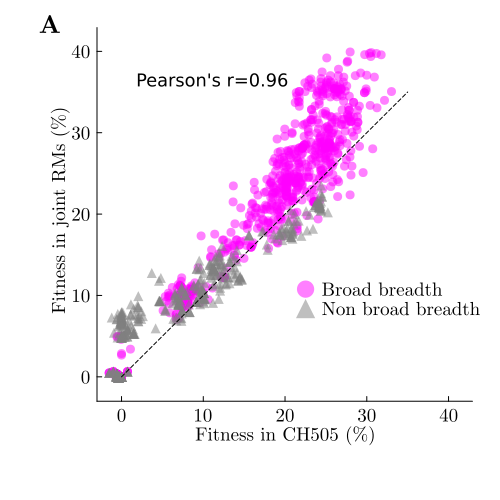

In [27]:
L_fig = 500
fontsize_reg = Int(ceil((2*L_fig)/α_gen_sgl * pxl2pt * (1.0/0.8))) # because we rescale these figures
fontsize_label_reg = Int(ceil((2*L_fig)/α_lbl_sgl * pxl2pt* (1.0/0.8)))
my_alpha = 0.5

fitness_ind_tot_CH505_random_set_vec = copy(reduce(vcat, fitness_ind_tot_CH505_random_set))
fitness_ind_tot_RMs_random_set_vec = copy(reduce(vcat, fitness_ind_tot_RMs_random_set))

max_x = maximum([maximum(fitness_ind_tot_CH505_random_set_vec), maximum(fitness_ind_tot_RMs_random_set_vec)]) + 3
p1tot = scatter(fitness_ind_tot_CH505_random_set_vec[Bool.(bool_BNB_nonBNB)], 
            fitness_ind_tot_RMs_random_set_vec[Bool.(bool_BNB_nonBNB)],
            label="Broad breadth", 
            c=:magenta, 
            alpha=my_alpha,
            foreground_color_legend = nothing,
            labelfontsize=fontsize_reg,
            xlim=(-3, max_x), 
            ylim=(-3, max_x), 
            markerstrokewidth=0,
            grid=:false,
            m = :circle,
            margin=my_margin, 
            xlabel="Fitness in CH505 (%)\n ", 
            ylabel=" \n Fitness in joint RMs (%)",
            legend=(0.6, 0.3),
            legendfontsize=fontsize_reg, 
            tickfontsize=fontsize_reg,
)
scatter!(fitness_ind_tot_CH505_random_set_vec[.!Bool.(bool_BNB_nonBNB)], 
            fitness_ind_tot_RMs_random_set_vec[.!Bool.(bool_BNB_nonBNB)],
            label="Non broad breadth", 
            c=:gray, 
            alpha=my_alpha,
            foreground_color_legend = nothing,
            labelfontsize=fontsize_reg,
            xlim=(-3, max_x), 
            ylim=(-3, max_x), 
            markerstrokewidth=0,
            legend=(0.6, 0.3),
            m =:utriangle,
)
pearson_cor = cor(fitness_ind_tot_CH505_random_set_vec, fitness_ind_tot_RMs_random_set_vec);
annotate!(2, max_x*0.85, text(@sprintf("Pearson's r=%.2f", pearson_cor), 
        fontsize_reg, :left, rotation=0, color=:black))
Plots.plot!(p1tot[1], collect(0:35), collect(0:35), sybplot=1, c="black", linestyle=:dash, label=:false)
annotate!(-10, max_x*1.01, text(L"\textbf{A}", :left, fontsize_label_reg))

Plots.plot(p1tot, size=(L_fig, L_fig))


In [28]:
# -------- Export the data for Fig4A, comparison of CH505 and jointed RMs fitness landscapes  -------#
df = DataFrame( F_CH505 = fitness_ind_tot_CH505_random_set_vec,
                F_jointedRMs = fitness_ind_tot_RMs_random_set_vec,
                breadth = bool_BNB_nonBNB );
#CSV.write("../out/for_figures/fig4A_fitness_comparison.csv", df); 

### Shuffled sequences 

In [29]:
dir_name = "../data/mpl/SHIV.CH505_AA/"
(fitness_ind_tot_CH505_shuffle_set, fitness_ind_tot_RMs_shuffle_set, 
 mean_fitness_ind_tot_CH505_shuffle_set, mean_fitness_ind_tot_RMs_shuffle_set,     
 errorbar_tot_CH505_shuffle_set, errorbar_tot_RMs_shuffle_set, 
    date_unique_set_shuffle, bool_BNB_nonBNB_shuffle) = get_compare_fitness(fname_key_human_and_RMs, fname_dev, dir_name, 
                        csv_raw_CH505, csv_raw_RMs_merged; flag_include_HIV=false, flag_shuffle = true);

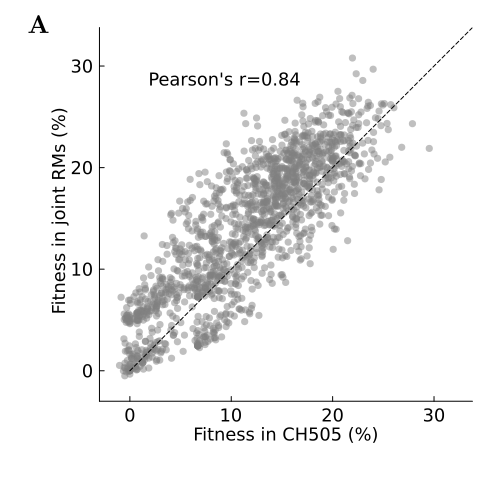

In [55]:
L_fig = 500
fontsize_reg = Int(ceil((2*L_fig)/α_gen_sgl * pxl2pt * (1.0/0.8))) # because we rescale these figures
fontsize_label_reg = Int(ceil((2*L_fig)/α_lbl_sgl * pxl2pt* (1.0/0.8)))
my_alpha = 0.5

fitness_ind_tot_CH505_shuffle_set_vec = copy(reduce(vcat, fitness_ind_tot_CH505_shuffle_set))
fitness_ind_tot_RMs_shuffle_set_vec = copy(reduce(vcat, fitness_ind_tot_RMs_shuffle_set))

max_x = maximum([maximum(fitness_ind_tot_CH505_shuffle_set_vec), maximum(fitness_ind_tot_RMs_shuffle_set_vec)]) + 3
p1tot = scatter(fitness_ind_tot_CH505_shuffle_set_vec[Bool.(bool_BNB_nonBNB_shuffle)], 
            fitness_ind_tot_RMs_shuffle_set_vec[Bool.(bool_BNB_nonBNB_shuffle)],
            legend=:false,
            c=:gray, 
            alpha=my_alpha,
            foreground_color_legend = nothing,
            labelfontsize=fontsize_reg,
            xlim=(-3, max_x), 
            ylim=(-3, max_x), 
            markerstrokewidth=0,
            grid=:false,
            m = :circle,
            margin=my_margin, 
            xlabel="Fitness in CH505 (%)\n ", 
            ylabel=" \n Fitness in joint RMs (%)",
            legendfontsize=fontsize_reg, 
            tickfontsize=fontsize_reg,
)
scatter!(fitness_ind_tot_CH505_shuffle_set_vec[.!Bool.(bool_BNB_nonBNB_shuffle)], 
            fitness_ind_tot_RMs_shuffle_set_vec[.!Bool.(bool_BNB_nonBNB_shuffle)],
            legend=:false,
            c=:gray, 
            alpha=my_alpha,
            foreground_color_legend = nothing,
            labelfontsize=fontsize_reg,
            xlim=(-3, max_x), 
            ylim=(-3, max_x), 
            markerstrokewidth=0,
            m =:circle,
)
pearson_cor = cor(fitness_ind_tot_CH505_shuffle_set_vec, fitness_ind_tot_RMs_shuffle_set_vec);
annotate!(2, max_x*0.85, text(@sprintf("Pearson's r=%.2f", pearson_cor), 
        fontsize_reg, :left, rotation=0, color=:black))
Plots.plot!(p1tot[1], collect(0:35), collect(0:35), sybplot=1, c="black", linestyle=:dash, label=:false)
annotate!(-10, max_x*1.01, text(L"\textbf{A}", :left, fontsize_label_reg))

Plots.plot(p1tot, size=(L_fig, L_fig))


In [56]:
# -------- Export the data for Fig4A, comparison of CH505 and jointed RMs fitness landscapes  -------#
df = DataFrame( F_CH505 = fitness_ind_tot_CH505_shuffle_set_vec,
                F_jointedRMs = fitness_ind_tot_RMs_shuffle_set_vec,
                breadth = bool_BNB_nonBNB_shuffle );
#CSV.write("../out/for_figures/figS3A_fitness_comparison_using_shuffled_seq.csv", df); 

## Fitness change Plots 

α_dev=0.214 α_undev=0.062 


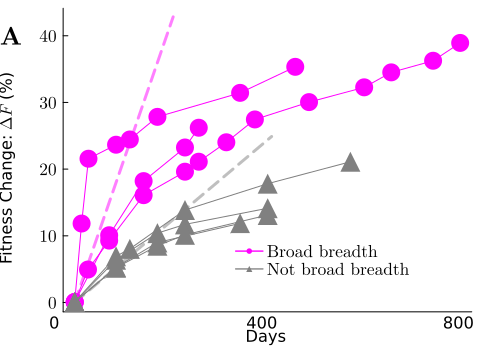

In [30]:
# This figure would be double column
n_H_RMs = length(fname_key_human_and_RMs)
k = 1
L_fig_tot = 1200
L_fig = Int(0.4*L_fig_tot)
fontsize_reg = Int(ceil(L_fig_tot/α_gen_sgl * pxl2pt))
fontsize_label_reg = Int(ceil(L_fig_tot/α_lbl_sgl * pxl2pt))

my_ms = 10
α_lin_dev = linreg(date_unique_set[k][1:4], mean_fitness_ind_tot_RMs_random_set[k][1:4])
for k_temp in 2:4 α_lin_dev += linreg(date_unique_set[k_temp][1:4], mean_fitness_ind_tot_RMs_random_set[k_temp][1:4]) end

α_lin_undev = linreg(date_unique_set[4][1:3], mean_fitness_ind_tot_RMs_random_set[4][1:3])
for k_temp in 5:7 α_lin_undev += linreg(date_unique_set[k_temp][1:3], mean_fitness_ind_tot_RMs_random_set[k_temp][1:3]) end

α_lin_dev /= 3; α_lin_undev /= 4
@printf("α_dev=%.3f α_undev=%.3f \n", α_lin_dev, α_lin_undev)

p = Plots.plot(collect(0:100:250), α_lin_dev*collect(0:100:250), linestyle=:dash, c=:magenta, label=:false, lw=3, alpha=0.5)
Plots.plot!(collect(0:100:400), α_lin_undev*collect(0:100:400), linestyle=:dash, c=:gray, label=:false, lw=3, alpha=0.5)

plot!(date_unique_set[k], mean_fitness_ind_tot_RMs_random_set[k], 
#    m=Symbol(marker_set_with_human[k]), label=fname_key_human_and_RMs[k],     
    m=Symbol(marker_set_with_human[k+1]), label="Broad breadth",
    yerror=errorbar_tot_RMs_set[k],
    markerstrokecolor="magenta",
    c="magenta",
    size=(L_fig,Int(350)),
    foreground_color_legend = nothing,
    labelfontsize=fontsize_reg,
    grid=:false,
    margin=0.1mm, 
    ms=my_ms,
    xlabel=" \n ", 
    ylabel=" \n ", 
    xticks=:false,
#    xlim=(-10, 900),
    legend=(0.5, 0.2),
#    legend=:false,
    legendfontsize=fontsize_reg, 
    tickfontsize=fontsize_reg,
)
annotate!(-140, 6, text(L"Fitness Change: $ΔF$ (%)", fontsize_reg, :left, rotation=90))
annotate!(350, -5, text("Days", fontsize_reg, :left))
[annotate!(i-50, -3, text(string(i), fontsize_reg, :left)) for i in [0, 400, 800]]

for k in 2:(n_H_RMs-1)
    key_RM = fname_key_human_and_RMs[k+1]
    this_c = "gray"
    if(key_RM ∈ fname_dev) this_c = "magenta" end
#    if(key_RM == "RM6072") this_c = "pink" end
    if(k==4)
        plot!(p[1], date_unique_set[k], mean_fitness_ind_tot_RMs_random_set[k], ms=my_ms,
            yerror=errorbar_tot_RMs_set[k], markerstrokecolor=this_c,
            sbuplot=1, m=Symbol(marker_set_with_human[k+1]), label="Not broad breadth", c=this_c)
    end
    if(k!=4)
        plot!(p[1], date_unique_set[k], mean_fitness_ind_tot_RMs_random_set[k], ms=my_ms,
            yerror=errorbar_tot_RMs_set[k], markerstrokecolor=this_c,
            sbuplot=1, m=Symbol(marker_set_with_human[k+1]), label=:false, c=this_c)
    end
end
#display(p);
annotate!(-150, 40, text(L"\textbf{A}", :left, fontsize_label_reg))
#Plots.savefig("../fig/CH505/fitness_change_mutations_left_fig.pdf")




In [31]:
dir_name = "../data/mpl/SHIV.CH505_AA/"

##Note this function exclude HIV because the flag_include_HIV is off.
(fitness_ind_tot_CH505_random_set, fitness_ind_tot_RMs_random_set, 
 mean_fitness_ind_tot_CH505_random_set, mean_fitness_ind_tot_RMs_random_set,     
 errorbar_tot_CH505_set, errorbar_tot_RMs_set, 
    date_unique_set, bool_BNB_nonBNB) = get_compare_fitness(fname_key_human_and_RMs, fname_dev, dir_name, 
                        csv_raw_CH505, csv_raw_RMs_merged; flag_include_HIV=false, flag_shuffle = false);

#RM_id = [@sprintf("RM%d", k) for k in 1:size(date_unique_set,1) for _ in date_unique_set[k]]
RM_id = [fname_key_human_and_RMs[k+1] for k in 1:size(date_unique_set,1) for _ in date_unique_set[k]]
#breadth = [x ∈ ["RM1", "RM2", "RM3"]  for x in RM_id ]
breadth = [x ∈ fname_key_human_and_RMs[1:4]  for x in RM_id ]
date = [item for sublist in date_unique_set for item in sublist]
mean_F = [item for sublist in mean_fitness_ind_tot_RMs_random_set for item in sublist]
std_F = [item for sublist in errorbar_tot_RMs_set for item in sublist];
#"""
# --- Adding CH505's data --- #
dir_name = "../data/mpl/SHIV.CH505_AA/"
(fitness_ind_tot_CH505_random_set, fitness_ind_tot_RMs_random_set, 
 mean_fitness_ind_tot_CH505_random_set, mean_fitness_ind_tot_RMs_random_set,     
 errorbar_tot_CH505_set, errorbar_tot_RMs_set, 
    date_unique_set, bool_BNB_nonBNB) = get_compare_fitness(fname_key_human_and_RMs, fname_dev, dir_name, 
                        csv_raw_CH505, csv_raw_RMs_merged; flag_include_HIV=true, flag_shuffle = false);

RM_id = [copy(RM_id); ["CH505" for _ in date_unique_set[1]]]    
breadth = [copy(breadth); [true for _ in date_unique_set[1]]]
date = [copy(date); date_unique_set[1]]
mean_F = [copy(mean_F); mean_fitness_ind_tot_CH505_random_set[1]]
std_F = [copy(std_F); errorbar_tot_CH505_set[1]];
#"""

df = DataFrame(
RM_id = RM_id,
breadth = breadth,
date = date,
mean_F = mean_F,
std_F = std_F);   
#CSV.write("../out/for_figures/fig6A_fitness_change.csv", df);

## Including HIV sequences for projection onto the jont RMs fitness landscape.

## Characterize RMs developed bnAbs and ddn't develop bnAbs  

In [113]:
dir_name = "../data/mpl/SHIV.CH505_AA/"
L_fig_tot = 1200# 3600
(plot_selected_heatmap, heatmap_BNB_or_nonBNB, mutation_names_BNB_or_nonBNB, heatmap_only_BNB, mutation_names_only_BNB) = get_heatmap_selected_mutations_CH505(dir_name, L_fig_tot);


In [115]:
flat_mat_value = []
category_name = []
model_name = []
mutation_name = []
location_name = []
#model_name_list = reverse(["jointed_RMs"; [@sprintf("RM%d", i) for i in 1:7]])
model_name_list = reverse(["jointed_RMs"; [fname_key_human_and_RMs[i] for i in 2:8]])
for i in 1:size(heatmap_BNB_or_nonBNB, 1)
    for j in 1:size(heatmap_BNB_or_nonBNB, 2)
        push!(model_name, model_name_list[i])
        mut_name_temp = mutation_names_BNB_or_nonBNB[j]
        push!(mutation_name, mut_name_temp)
        push!(category_name, "BNB_or_nonBNB")
        if(isnothing(get_variable_regions(extract_integer(mut_name_temp))))
            push!(location_name, "NaN")
        else
            push!(location_name, get_variable_regions(extract_integer(mut_name_temp)))
        end
            
        if(heatmap_BNB_or_nonBNB[i,j]>-0.09)
            push!(flat_mat_value, heatmap_BNB_or_nonBNB[i,j])
        else
            push!(flat_mat_value, "NaN")
        end
    end
end
for i in 1:size(heatmap_only_BNB, 1)
    for j in 1:size(heatmap_only_BNB, 2)
        push!(model_name, model_name_list[i])
        mut_name_temp = mutation_names_only_BNB[j]
        push!(mutation_name, mut_name_temp)
        push!(category_name, "only_BNB")
        if(isnothing(get_variable_regions(extract_integer(mut_name_temp))))
            push!(location_name, "NaN")
        else
            push!(location_name, get_variable_regions(extract_integer(mut_name_temp)))
        end
        if(heatmap_only_BNB[i,j]>-0.09)
            push!(flat_mat_value, heatmap_only_BNB[i,j])
        else
            push!(flat_mat_value, "NaN")
        end
    end
end
        

In [117]:
df = DataFrame(
    category = category_name, 
    model = model_name,
    mutation = mutation_name,
    location = location_name,
    selection = flat_mat_value
)
#CSV.write("../out/for_figures/fig6B_selected_mutations.csv", df);

## Compare correlation of fitness landscapes among the all subjects

In [362]:
# ------------ Get heatmap of the Pearson's r matrix ------------#
L_fig = 500
n_rand_max=1
dir_name = "../data/mpl/SHIV.CH505_AA/"
fname_key_in = "703010505" # This is the id of sequences that are projected onto the spaces. 
title_fig = "SHIV.CH505"
#fname_key_human_and_RMs
shuffle_flag = true
(p_out, p_out_v2, cor_mat_smry, cor_mat_smry_std, spearman_mat_smry, 
    spearman_mat_smry_std, slope_mat_smry, slope_mat_smry_std) = get_correlation_sumamry(fname_key_human_and_RMs, dir_name, 
    title_fig, fname_key_in, L_fig, n_rand_max, shuffle_flag);


len_k, len_m = 578, 578
len_k, len_m = 578, 578
len_k, len_m = 578, 578
len_k, len_m = 578, 578
len_k, len_m = 578, 578
len_k, len_m = 578, 578
len_k, len_m = 578, 578
len_k, len_m = 578, 578
len_k, len_m = 578, 578
len_k, len_m = 578, 578
len_k, len_m = 578, 578
len_k, len_m = 578, 578
len_k, len_m = 578, 578
len_k, len_m = 578, 578
len_k, len_m = 578, 578
len_k, len_m = 578, 578
len_k, len_m = 578, 578
len_k, len_m = 578, 578
len_k, len_m = 578, 578
len_k, len_m = 578, 578
len_k, len_m = 578, 578
len_k, len_m = 578, 578
len_k, len_m = 578, 578
len_k, len_m = 578, 578
len_k, len_m = 578, 578
len_k, len_m = 578, 578
len_k, len_m = 578, 578
len_k, len_m = 578, 578
len_k, len_m = 578, 578
len_k, len_m = 578, 578
len_k, len_m = 578, 578
len_k, len_m = 578, 578
len_k, len_m = 578, 578
len_k, len_m = 578, 578
len_k, len_m = 578, 578
len_k, len_m = 578, 578


In [ ]:
Plots.plot(p_out, size=(600, 600) );

In [7]:
#Plots.savefig("../fig/Fitness_similarity_all_to_all_CH505_without_shuffle.png")
#Plots.plot(p_out_v2, size=(600, 600) )

## Comapre time when detected and selection coefficinet

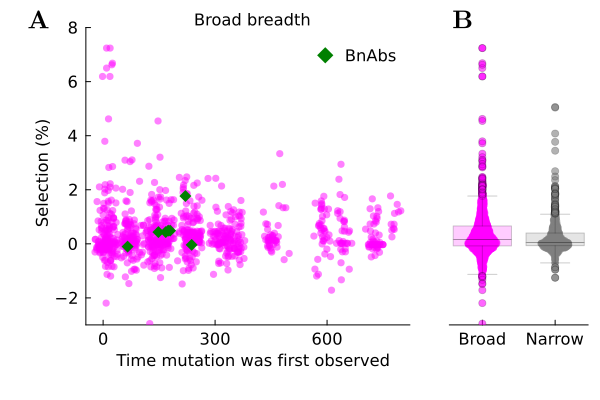

In [187]:
# -------- Make Selection vs time plot for SHIV dsata ---------#
dir_name= "../data/mpl/SHIV.CH505_AA/"
L_fig_tot = 1200
(p1, p_violin, s_BNB_set, date_BNB_set, s_notBNB_set, date_notBNB_set, date_bnAbs_RMs, s_bnAbs_RMs) = get_selection_vs_time_SHIV505(dir_name, L_fig_tot);

l = @layout[a{0.7w} b{0.3w}]
Plots.plot(p1,p_violin, layout=l, size=(L_fig_tot*0.5, 400))
#Plots.savefig("../fig/CH505/Selection_vs_time_RMs_CH505.pdf")

### The following cells obtain trajectories and mutations that involved in glycan and/or resistant to bnAbs. 

In [32]:
# At the directory for the /data/mpl/SHIV.CH505_AA/ there are fies named RM<id>-poly.csv with names of mutaions. 
# Given TF's amino acid sequences, we should be able to identify the mutations that alter the glycan and its trajectories. 

TF_seq_aa_raw = DataFrame(CSV.File("../data/mpl/SHIV.CH505_AA/index-703010505.csv"));
TF_aa = String.(TF_seq_aa_raw.TF)
TF_seq = TF_aa
TF_HXB2 = String.(TF_seq_aa_raw.HXB2);
len_seq = length(TF_HXB2);

In [33]:
individual_set = []
id_set_csv = []; types_set_csv = []
date_set_csv = []; mutation_name_set_csv = [];  freq_set_csv = []
#
date_mutation_was_detected_s_vs_t = []
id_set_s_vs_t = []; types_set_s_vs_t = []; individual_set_s_vs_t = []
mutations_set_s_vs_t = []; selection_set_s_vs_t = []; selection_RMs_set_s_vs_t = []
mutation_resistant_bnAbs = ["R166K", "R169K", "K169E"];
VL_enhancing = ["N130D", "N279D", "K302N", "Y330H", "N334S", "H417R"]
fname_Human_RM = ["703010505", "RM5695", "RM6072", "RM6701", "RM6699", "RM6697", "RM6070", "RM6703"];

csv_raw_RMs = DataFrame(CSV.File("../data/mpl/SHIV.CH505_AA/RMs-poly.csv"));
for i_HRM in 2:length(fname_Human_RM)
    csv_raw_in = DataFrame(CSV.File(@sprintf("../data/mpl/SHIV.CH505_AA/%s-poly.csv", fname_Human_RM[i_HRM])));
    (extracted_integers, index_to_find_integers) = get_date_of_freq(csv_raw_in)
    n_mutation_selected = 0
    for n in 1:length(csv_raw_in.mutation)
        x = csv_raw_in.mutation[n]
        x_splited = split(x, "")
        date_detected = 1
        if(fname_Human_RM[i_HRM] != "RMs")
            date_detected = csv_raw_in.date[n]
        end
        mut_wt = x_splited[1]; mut_mt = x_splited[end]
        i_hxb2 = join(x_splited[2:(end-1)])
        #@printf("%s, %s, %s\n", i_hxb2, mut_wt, mut_mt)
        if( i_hxb2 ∈ TF_HXB2 && (date_detected > 0))
            i_seq = collect(1:len_seq)[TF_HXB2 .== i_hxb2][1]        
            n_mutation_selected += 1
            TF_AA = String(TF_seq[i_seq])
            mut_AA = String(mut_mt)
            (n_glycan_plus, n_glycan_minus) = get_glycosylation_simple_AA(i_seq, mut_AA, TF_seq, len_seq)
            #@printf("%d %d\n", n_glycan_plus, n_glycan_minus)
            
            if(n_glycan_plus>0 || n_glycan_minus>0)
                mutation_id = join([fname_Human_RM[i_HRM], n_mutation_selected], ".")
                
                #types_of_mutation = "glycan" 
                types_of_mutation = "glycan_shield"
                if(n_glycan_minus>0)
                    types_of_mutation = "glycan_holes"
                end
                if(n_glycan_minus>0 && n_glycan_plus>0)
                    types_of_mutation = "glycan_shift"
                end
                
                push!(individual_set_s_vs_t, fname_Human_RM[i_HRM])
                push!(date_mutation_was_detected_s_vs_t, date_detected)
                push!(id_set_s_vs_t, mutation_id)
                push!(types_set_s_vs_t, types_of_mutation)
                push!(mutations_set_s_vs_t, csv_raw_in.mutation[n])
                push!(selection_set_s_vs_t, csv_raw_in.s_MPL[n])
                id_find_mutations = csv_raw_RMs.mutation .== csv_raw_in.mutation[n]
                if(count(id_find_mutations)>0)
                    push!(selection_RMs_set_s_vs_t, csv_raw_RMs.s_MPL[id_find_mutations][1])
                else
                    push!(selection_RMs_set_s_vs_t, 0.0)
                end
                #
                for (date_this, index_this) in zip(extracted_integers, index_to_find_integers)
                    push!(individual_set, fname_Human_RM[i_HRM])
                    date_this_mutation = date_this # this information is used for making trajectory plots.
                    freq_this = csv_raw_in[n, index_this]
                    push!(id_set_csv, mutation_id)
                    push!(types_set_csv, types_of_mutation)
                    push!(date_set_csv, date_this_mutation)
                    push!(mutation_name_set_csv, csv_raw_in.mutation[n])
                    push!(freq_set_csv, freq_this)
                end
            end
        end
        #
        if(x ∈ mutation_resistant_bnAbs && (date_detected > 0))
            n_mutation_selected += 1
            mutation_id = join([fname_Human_RM[i_HRM], n_mutation_selected], ".")
            types_of_mutation = "bnAbs_resistance" 
            push!(individual_set_s_vs_t, fname_Human_RM[i_HRM])
            push!(date_mutation_was_detected_s_vs_t, date_detected)
            push!(id_set_s_vs_t, mutation_id)
            push!(types_set_s_vs_t, types_of_mutation)
            push!(mutations_set_s_vs_t, csv_raw_in.mutation[n])
            push!(selection_set_s_vs_t, csv_raw_in.s_MPL[n])
            id_find_mutations = csv_raw_RMs.mutation .== csv_raw_in.mutation[n]
            if(count(id_find_mutations)>0)
                push!(selection_RMs_set_s_vs_t, csv_raw_RMs.s_MPL[id_find_mutations][1])
            else
                push!(selection_RMs_set_s_vs_t, 0.0)
            end
            for (date_this, index_this) in zip(extracted_integers, index_to_find_integers)
                push!(individual_set, fname_Human_RM[i_HRM])
                date_this_mutation = date_this # this information is used for making trajectory plots.
                freq_this = csv_raw_in[n, index_this]
                push!(id_set_csv, mutation_id)
                push!(types_set_csv, types_of_mutation)
                push!(date_set_csv, date_this_mutation)
                push!(mutation_name_set_csv, csv_raw_in.mutation[n])
                push!(freq_set_csv, freq_this)
            end
        end
        if(x ∈ VL_enhancing && (date_detected > 0))
            n_mutation_selected += 1
            mutation_id = join([fname_Human_RM[i_HRM], n_mutation_selected], ".")
            types_of_mutation = "increase_VL" 
            push!(individual_set_s_vs_t, fname_Human_RM[i_HRM])
            push!(date_mutation_was_detected_s_vs_t, date_detected)
            push!(id_set_s_vs_t, mutation_id)
            push!(types_set_s_vs_t, types_of_mutation)
            push!(mutations_set_s_vs_t, csv_raw_in.mutation[n])
            push!(selection_set_s_vs_t, csv_raw_in.s_MPL[n])
            id_find_mutations = csv_raw_RMs.mutation .== csv_raw_in.mutation[n]
            if(count(id_find_mutations)>0)
                push!(selection_RMs_set_s_vs_t, csv_raw_RMs.s_MPL[id_find_mutations][1])
            else
                push!(selection_RMs_set_s_vs_t, 0.0)
            end
            push!(selection_RMs_set_s_vs_t, )
            for (date_this, index_this) in zip(extracted_integers, index_to_find_integers)
                push!(individual_set, fname_Human_RM[i_HRM])
                date_this_mutation = date_this # this information is used for making trajectory plots.
                freq_this = csv_raw_in[n, index_this]
                push!(id_set_csv, mutation_id)
                push!(types_set_csv, types_of_mutation)
                push!(date_set_csv, date_this_mutation)
                push!(mutation_name_set_csv, csv_raw_in.mutation[n])
                push!(freq_set_csv, freq_this)
            end
        end
    end
end


In [ ]:
df = DataFrame(
    individual = individual_set, 
    id = id_set_csv,
    types = types_set_csv,
    date = date_set_csv,
    mutation = mutation_name_set_csv,
    frequency = freq_set_csv
);
#CSV.write("../out/for_figures/trajectories_RMs_SHIVCH505.csv", df);
#
df = DataFrame(
    individual = individual_set_s_vs_t, 
    id = id_set_s_vs_t,
    types = types_set_s_vs_t,
    date = date_mutation_was_detected_s_vs_t,
    mutation = mutations_set_s_vs_t,
    selection = selection_set_s_vs_t, 
    selection_RMs = selection_RMs_set_s_vs_t
);
#CSV.write("../out/for_figures/selection_RMs_SHIVCH505.csv", df);

##  Including all mutations 

In [37]:


individual_set = []
id_set_csv = []; types_set_csv = []
date_set_csv = []; mutation_name_set_csv = [];  freq_set_csv = []
#
date_mutation_was_detected_s_vs_t = []
id_set_s_vs_t = []; types_set_s_vs_t = []; individual_set_s_vs_t = []
mutations_set_s_vs_t = []; selection_set_s_vs_t = []; selection_RMs_set_s_vs_t = []
mutation_resistant_bnAbs = ["R166K", "R169K", "K169E"];
VL_enhancing = ["N130D", "N279D", "K302N", "Y330H", "N334S", "H417R"]
fname_Human_RM = ["703010505", "RM5695", "RM6072", "RM6701", "RM6699", "RM6697", "RM6070", "RM6703"];

csv_raw_RMs = DataFrame(CSV.File("../data/mpl/SHIV.CH505_AA/RMs-poly.csv"));
for i_HRM in 2:length(fname_Human_RM)
    csv_raw_in = DataFrame(CSV.File(@sprintf("../data/mpl/SHIV.CH505_AA/%s-poly.csv", fname_Human_RM[i_HRM])));
    (extracted_integers, index_to_find_integers) = get_date_of_freq(csv_raw_in)
    n_mutation_selected = 0
    for n in 1:length(csv_raw_in.mutation)
        x = csv_raw_in.mutation[n]
        x_splited = split(x, "")
        date_detected = 1
        if(fname_Human_RM[i_HRM] != "RMs")
            date_detected = csv_raw_in.date[n]
        end
        mut_wt = x_splited[1]; mut_mt = x_splited[end]
        i_hxb2 = join(x_splited[2:(end-1)])
        #@printf("%s, %s, %s\n", i_hxb2, mut_wt, mut_mt)
        if( i_hxb2 ∈ TF_HXB2 && i_hxb2 != "375" && (date_detected > 0))
            i_seq = collect(1:len_seq)[TF_HXB2 .== i_hxb2][1]        
            n_mutation_selected += 1
            TF_AA = String(TF_seq[i_seq])
            mut_AA = String(mut_mt)
            (n_glycan_plus, n_glycan_minus) = get_glycosylation_simple_AA(i_seq, mut_AA, TF_seq, len_seq)
            #@printf("%d %d\n", n_glycan_plus, n_glycan_minus)
            
            if(n_glycan_plus>0 || n_glycan_minus>0)
                mutation_id = join([fname_Human_RM[i_HRM], n_mutation_selected], ".")
                
                #types_of_mutation = "glycan" 
                types_of_mutation = "glycan_shield"
                if(n_glycan_minus>0)
                    types_of_mutation = "glycan_holes"
                end
                if(n_glycan_minus>0 && n_glycan_plus>0)
                    types_of_mutation = "glycan_shift"
                end
                
                push!(individual_set_s_vs_t, fname_Human_RM[i_HRM])
                push!(date_mutation_was_detected_s_vs_t, date_detected)
                push!(id_set_s_vs_t, mutation_id)
                push!(types_set_s_vs_t, types_of_mutation)
                push!(mutations_set_s_vs_t, csv_raw_in.mutation[n])
                push!(selection_set_s_vs_t, csv_raw_in.s_MPL[n])
                id_find_mutations = csv_raw_RMs.mutation .== csv_raw_in.mutation[n]
                if(count(id_find_mutations)>0)
                    push!(selection_RMs_set_s_vs_t, csv_raw_RMs.s_MPL[id_find_mutations][1])
                else
                    push!(selection_RMs_set_s_vs_t, 0.0)
                end
                #
                for (date_this, index_this) in zip(extracted_integers, index_to_find_integers)
                    push!(individual_set, fname_Human_RM[i_HRM])
                    date_this_mutation = date_this # this information is used for making trajectory plots.
                    freq_this = csv_raw_in[n, index_this]
                    push!(id_set_csv, mutation_id)
                    push!(types_set_csv, types_of_mutation)
                    push!(date_set_csv, date_this_mutation)
                    push!(mutation_name_set_csv, csv_raw_in.mutation[n])
                    push!(freq_set_csv, freq_this)
                end
            elseif((date_detected >0) && (x ∉ mutation_resistant_bnAbs) && (x ∉ VL_enhancing)  )
                mutation_id = join([fname_Human_RM[i_HRM], n_mutation_selected], ".")
                types_of_mutation = "else"
                push!(individual_set_s_vs_t, fname_Human_RM[i_HRM])
                push!(date_mutation_was_detected_s_vs_t, date_detected)
                push!(id_set_s_vs_t, mutation_id)
                push!(types_set_s_vs_t, types_of_mutation)
                push!(mutations_set_s_vs_t, csv_raw_in.mutation[n])
                push!(selection_set_s_vs_t, csv_raw_in.s_MPL[n])
                id_find_mutations = csv_raw_RMs.mutation .== csv_raw_in.mutation[n]
                if(count(id_find_mutations)>0)
                    push!(selection_RMs_set_s_vs_t, csv_raw_RMs.s_MPL[id_find_mutations][1])
                else
                    push!(selection_RMs_set_s_vs_t, 0.0)
                end
                #
                for (date_this, index_this) in zip(extracted_integers, index_to_find_integers)
                    push!(individual_set, fname_Human_RM[i_HRM])
                    date_this_mutation = date_this # this information is used for making trajectory plots.
                    freq_this = csv_raw_in[n, index_this]
                    push!(id_set_csv, mutation_id)
                    push!(types_set_csv, types_of_mutation)
                    push!(date_set_csv, date_this_mutation)
                    push!(mutation_name_set_csv, csv_raw_in.mutation[n])
                    push!(freq_set_csv, freq_this)
                end
            end
        end
        #
        if(x ∈ mutation_resistant_bnAbs && (date_detected > 0))
            n_mutation_selected += 1
            mutation_id = join([fname_Human_RM[i_HRM], n_mutation_selected], ".")
            types_of_mutation = "bnAbs_resistance" 
            push!(individual_set_s_vs_t, fname_Human_RM[i_HRM])
            push!(date_mutation_was_detected_s_vs_t, date_detected)
            push!(id_set_s_vs_t, mutation_id)
            push!(types_set_s_vs_t, types_of_mutation)
            push!(mutations_set_s_vs_t, csv_raw_in.mutation[n])
            push!(selection_set_s_vs_t, csv_raw_in.s_MPL[n])
            id_find_mutations = csv_raw_RMs.mutation .== csv_raw_in.mutation[n]
            if(count(id_find_mutations)>0)
                push!(selection_RMs_set_s_vs_t, csv_raw_RMs.s_MPL[id_find_mutations][1])
            else
                push!(selection_RMs_set_s_vs_t, 0.0)
            end
            for (date_this, index_this) in zip(extracted_integers, index_to_find_integers)
                push!(individual_set, fname_Human_RM[i_HRM])
                date_this_mutation = date_this # this information is used for making trajectory plots.
                freq_this = csv_raw_in[n, index_this]
                push!(id_set_csv, mutation_id)
                push!(types_set_csv, types_of_mutation)
                push!(date_set_csv, date_this_mutation)
                push!(mutation_name_set_csv, csv_raw_in.mutation[n])
                push!(freq_set_csv, freq_this)
            end
        end
        if(x ∈ VL_enhancing && (date_detected > 0))
            n_mutation_selected += 1
            mutation_id = join([fname_Human_RM[i_HRM], n_mutation_selected], ".")
            types_of_mutation = "increase_VL" 
            push!(individual_set_s_vs_t, fname_Human_RM[i_HRM])
            push!(date_mutation_was_detected_s_vs_t, date_detected)
            push!(id_set_s_vs_t, mutation_id)
            push!(types_set_s_vs_t, types_of_mutation)
            push!(mutations_set_s_vs_t, csv_raw_in.mutation[n])
            push!(selection_set_s_vs_t, csv_raw_in.s_MPL[n])
            id_find_mutations = csv_raw_RMs.mutation .== csv_raw_in.mutation[n]
            if(count(id_find_mutations)>0)
                push!(selection_RMs_set_s_vs_t, csv_raw_RMs.s_MPL[id_find_mutations][1])
            else
                push!(selection_RMs_set_s_vs_t, 0.0)
            end
            push!(selection_RMs_set_s_vs_t, )
            for (date_this, index_this) in zip(extracted_integers, index_to_find_integers)
                push!(individual_set, fname_Human_RM[i_HRM])
                date_this_mutation = date_this # this information is used for making trajectory plots.
                freq_this = csv_raw_in[n, index_this]
                push!(id_set_csv, mutation_id)
                push!(types_set_csv, types_of_mutation)
                push!(date_set_csv, date_this_mutation)
                push!(mutation_name_set_csv, csv_raw_in.mutation[n])
                push!(freq_set_csv, freq_this)
            end
        end
    end
end


In [38]:
df = DataFrame(
    individual = individual_set, 
    id = id_set_csv,
    types = types_set_csv,
    date = date_set_csv,
    mutation = mutation_name_set_csv,
    frequency = freq_set_csv
);
CSV.write("../out/for_figures/trajectories_RMs_SHIVCH505_tot.csv", df);
#
df = DataFrame(
    individual = individual_set_s_vs_t, 
    id = id_set_s_vs_t,
    types = types_set_s_vs_t,
    date = date_mutation_was_detected_s_vs_t,
    mutation = mutations_set_s_vs_t,
    selection = selection_set_s_vs_t, 
    selection_RMs = selection_RMs_set_s_vs_t
);
CSV.write("../out/for_figures/selection_RMs_SHIVCH505_tot.csv", df);

## check the number of the common mutations acorss macques. 

In [187]:
csv_raw_RMs = DataFrame(CSV.File("../data/mpl/SHIV.CH505_AA/RMs-poly.csv"));
idx_to_look = extract_integer.(csv_raw_RMs.mutation) .!= 375
csv_raw_RMs = copy(csv_raw_RMs[idx_to_look, :])
selection_vector_set_all = []
for i_HRM in 2:length(fname_Human_RM)
    csv_raw_in = DataFrame(CSV.File(@sprintf("../data/mpl/SHIV.CH505_AA/%s-poly.csv", fname_Human_RM[i_HRM])));
    selection_vector_RM = []
    for n in 1:length(csv_raw_RMs.HXB2)
        mut_in = csv_raw_RMs.mutation[n]
        idx_detected = csv_raw_in.mutation .== mut_in
        if((count(idx_detected) > 0))
            s_in_str = @sprintf("%.6f", csv_raw_in.s_MPL[idx_detected][1])
            push!(selection_vector_RM, s_in_str)
        else
            push!(selection_vector_RM, "NaN")
        end;
    end
    push!(selection_vector_set_all, copy(selection_vector_RM) )
end;

# making csv files having selection coefficients estimated by individual, if there is no mutations then put NaN 
df = DataFrame(
    HXB2=csv_raw_RMs.HXB2,
    PRO=csv_raw_RMs.PRO,
    TF=csv_raw_RMs.TF,
    mutation=csv_raw_RMs.mutation,
    RMs=csv_raw_RMs.s_MPL,
    RM5695=selection_vector_set_all[1],
    RM6072=selection_vector_set_all[2],
    RM6701=selection_vector_set_all[3],
    RM6699=selection_vector_set_all[4],
    RM6697=selection_vector_set_all[5],
    RM6070=selection_vector_set_all[6],
    RM6703=selection_vector_set_all[7]
    ); 
#CSV.write("../out/for_figures/selection_RMs_summarizing_all_SHIVCH505.csv", df);

In [193]:
csv_summary = DataFrame(CSV.File("../out/for_figures/selection_RMs_summarizing_all_SHIVCH505.csv"));
n_macaques_threshold = 3;
idx_common_mutations = []
mean_s_set = []
for n in 1:length(csv_raw_RMs.HXB2)
    not_NaN = string.(collect(csv_summary[n, 6:end])) .!="NaN"
    if(count(not_NaN) > n_macaques_threshold)
        push!(idx_common_mutations, true)
        mean_s = mean(csv_summary[n, 5 .+ collect(1:7)[not_NaN] ])
        push!(mean_s_set, mean_s)
    else
        push!(idx_common_mutations, false)
        push!(mean_s_set, "NaN")
    end
        
end
idx_common_mutations = Bool.(idx_common_mutations);

df = DataFrame(
    HXB2=csv_raw_RMs.HXB2[idx_common_mutations],
    PRO=csv_raw_RMs.PRO[idx_common_mutations],
    TF=csv_raw_RMs.TF[idx_common_mutations],
    mutation=csv_raw_RMs.mutation[idx_common_mutations],
    RMs=csv_raw_RMs.s_MPL[idx_common_mutations],
    RM5695=selection_vector_set_all[1][idx_common_mutations],
    RM6072=selection_vector_set_all[2][idx_common_mutations],
    RM6701=selection_vector_set_all[3][idx_common_mutations],
    RM6699=selection_vector_set_all[4][idx_common_mutations],
    RM6697=selection_vector_set_all[5][idx_common_mutations],
    RM6070=selection_vector_set_all[6][idx_common_mutations],
    RM6703=selection_vector_set_all[7][idx_common_mutations], 
    mean_S=mean_s_set[idx_common_mutations]
    ); 
#CSV.write("../out/for_figures/selection_RMs_common_mutations_SHIVCH505.csv", df);

In [201]:
csv_in = DataFrame(CSV.File("../out/for_figures/selection_RMs_common_mutations_SHIVCH505.csv"));
idx_sorted = sortperm(csv_in.mean_S, rev=true)
df = DataFrame(
    HXB2=csv_in.HXB2[idx_sorted],
    PRO=csv_in.PRO[idx_sorted],
    TF=csv_in.TF[idx_sorted],
    mutation=csv_in.mutation[idx_sorted],
    RMs=csv_in.RMs[idx_sorted],
    RM5695=csv_in.RM5695[idx_sorted],
    RM6072=csv_in.RM6072[idx_sorted],
    RM6701=csv_in.RM6701[idx_sorted],
    RM6699=csv_in.RM6699[idx_sorted],
    RM6697=csv_in.RM6697[idx_sorted],
    RM6070=csv_in.RM6070[idx_sorted],
    RM6703=csv_in.RM6703[idx_sorted], 
    mean_S=csv_in.mean_S[idx_sorted]
    ); 
#CSV.write("../out/for_figures/selection_RMs_common_mutations_SHIVCH505_sorted.csv", df);

In [190]:
df = DataFrame(
    model = [repeat(["BNB"], length([date_BNB_set; date_bnAbs_RMs])); 
            repeat(["nonBNB"], length(date_notBNB_set))],
    date = [date_BNB_set; date_bnAbs_RMs; date_notBNB_set],
    selection = [s_BNB_set; s_bnAbs_RMs; s_notBNB_set],
    bnAbs = [[false for _ in 1:length(s_BNB_set)]; 
     [true for _ in 1:length(s_bnAbs_RMs)];
     [false for _ in 1:length(s_notBNB_set)]]);
#CSV.write("../out/for_figures/fig5AB_selection_vs_time_SHIV.csv", df); 

## Compare enrichment between HIV and SHIV

In [468]:
csv_raw_enrichment_Simian_HIV = DataFrame(CSV.File("../out/enrichment_grouped_SHIV_CH505_multiply_fraction.csv")) ;
csv_raw_enrichment_HIV = DataFrame(CSV.File("../out/enrichment_CH505_multiply_fraction.csv")) ;

In [469]:
field_names = names(csv_raw_enrichment_HIV);
col_typess = unique(csv_raw_enrichment_HIV[:, 1]);

In [470]:
i_type = 10
@printf("type: %s", col_typess[i_type])
idx_to_look = csv_raw_enrichment_HIV[:, 1] .== col_typess[i_type]
this_fraction = csv_raw_enrichment_HIV[idx_to_look, 2]
this_enrichment_HIV = csv_raw_enrichment_HIV.enrichment[idx_to_look]
this_enrichment_SHIV = csv_raw_enrichment_Simian_HIV.enrichment[idx_to_look];
this_log10P_HIV = csv_raw_enrichment_HIV.log10_P[idx_to_look]
this_log10P_SHIV = csv_raw_enrichment_Simian_HIV.log10_P[idx_to_look];

type: Shield

In [471]:
mean_en_HIV_set = []; mean_en_SHIV_set = []
std_en_HIV_set = []; std_en_SHIV_set = []; 
mean_lP_HIV_set = []; mean_lP_SHIV_set = []
std_lP_HIV_set = []; std_lP_SHIV_set = []
idx_to_look = csv_raw_enrichment_HIV[:, 1] .== col_typess[1]
this_enrichment_HIV = csv_raw_enrichment_HIV.enrichment[idx_to_look]
n_items = length(this_enrichment_HIV)
idx_x_percent = collect((n_items-2):(n_items-2))

for i_type in 1:length(col_typess)

    idx_to_look = csv_raw_enrichment_HIV[:, 1] .== col_typess[i_type]
    this_fraction = csv_raw_enrichment_HIV[idx_to_look, 2]
    this_enrichment_HIV = csv_raw_enrichment_HIV.enrichment[idx_to_look]
    this_enrichment_SHIV = csv_raw_enrichment_Simian_HIV.enrichment[idx_to_look];
    this_log10P_HIV = csv_raw_enrichment_HIV.log10_P[idx_to_look]
    this_log10P_SHIV = csv_raw_enrichment_Simian_HIV.log10_P[idx_to_look];
    
    cor_en = cor(this_enrichment_HIV, this_enrichment_SHIV)
    cor_lP = cor(this_log10P_HIV, this_log10P_SHIV)
    #@printf("ρ_en: %.4f, ρ_lP: %.4f", cor_en, cor_lP)
    p1 = scatter(100*this_fraction, this_enrichment_HIV, label="HIV")
    scatter!(100*this_fraction, this_enrichment_SHIV, label="SHIV", 
        xlabel="fraction (%)", ylabel="enrichment", title=@sprintf("%s (cor=%.2f)", col_typess[i_type], cor_en))
    p2 = scatter(100*this_fraction, this_log10P_HIV,)
    scatter!(100*this_fraction, this_log10P_SHIV .- 1, legend=:false, 
        xlabel="fraction (%)", ylabel="log P value", title=@sprintf("%s (cor=%.2f)", col_typess[i_type], cor_lP))
    
    cor_en = cor(this_enrichment_HIV[idx_x_percent], this_enrichment_SHIV[idx_x_percent] )
    cor_lP = cor(this_log10P_HIV[idx_x_percent], this_log10P_SHIV[idx_x_percent] .- 1)
    #@printf("ρ_en: %.4f, ρ_lP: %.4f", cor_en, cor_lP)
    p3 = scatter(100*this_fraction[idx_x_percent], this_enrichment_HIV[idx_x_percent], label="HIV")
    scatter!(100*this_fraction[idx_x_percent], this_enrichment_SHIV[idx_x_percent], label="SHIV", 
        xlabel="fraction (%)", ylabel="enrichment", title=@sprintf("%s (cor=%.2f)", col_typess[i_type], cor_en))
    p4 = scatter(100*this_fraction[idx_x_percent], this_log10P_HIV[idx_x_percent],)
    scatter!(100*this_fraction[idx_x_percent], this_log10P_SHIV[idx_x_percent] .-1, legend=:false, 
        xlabel="fraction (%)", ylabel="log P value", title=@sprintf("%s (cor=%.2f)", col_typess[i_type], cor_lP))
    Plots.plot(p1,p2, p3, p4, layout=(2,2), size=(700, 600))
    Plots.savefig(@sprintf("../fig_temp/compare_HIV_SHIV_%s.pdf", col_typess[i_type]))

    
    mean_en_HIV = median(this_enrichment_HIV[idx_x_percent]) 
    mean_en_SHIV = median(this_enrichment_SHIV[idx_x_percent]) 
    mean_lP_HIV = median(this_log10P_HIV[idx_x_percent]) 
    mean_lP_SHIV = median(this_log10P_SHIV[idx_x_percent]) 
    
    std_en_HIV = std(this_enrichment_HIV[idx_x_percent]) 
    std_en_SHIV = std(this_enrichment_SHIV[idx_x_percent]) 
    std_lP_HIV = std(this_log10P_HIV[idx_x_percent]) 
    std_lP_SHIV = std(this_log10P_SHIV[idx_x_percent]) 

    push!(mean_en_HIV_set, mean_en_HIV)
    push!(mean_en_SHIV_set, mean_en_SHIV)
    push!(mean_lP_HIV_set, mean_lP_HIV)
    push!(mean_lP_SHIV_set, mean_lP_SHIV)

    push!(std_en_HIV_set, std_en_HIV)
    push!(std_en_SHIV_set, std_en_SHIV)
    push!(std_lP_HIV_set, std_lP_HIV)
    push!(std_lP_SHIV_set, std_lP_SHIV)
end

In [472]:
marker_types = [:circle, :square, :diamond, :cross, :star5, :hexagon, :heptagon, :x, :utriangle, :pentagon, :star6, :dtriangle]
my_ms = 7
i_type = 1
p1 = scatter([mean_en_HIV_set[i_type]], [mean_en_SHIV_set[i_type]], title=L"\mathrm{Enrichment}", ms=my_ms, m=marker_types[i_type], 
    label=col_typess[i_type], legend=:outerright, xaxis=:log, yaxis=:log, xlabel="HIV", ylabel="SHIV")
cor_en = cor(log.(mean_en_HIV_set), log.(mean_en_SHIV_set))
annotate!(3, 60,text(@sprintf("r=%.2f", cor_en), ) )
 
    p2 = scatter([mean_lP_HIV_set[1]], [mean_lP_SHIV_set[1]] , title=L"\log P", ms=my_ms, m=marker_types[i_type], 
    label=col_typess[i_type], legend=:outerright, xlabel="HIV", ylabel="SHIV")
cor_lP = cor(mean_lP_HIV_set, mean_lP_SHIV_set)
annotate!(-6, -4, text(@sprintf("r=%.2f", cor_lP), ) )
for i_type in 2:length(col_typess)
    scatter!(p1[1], [mean_en_HIV_set[i_type]], [mean_en_SHIV_set[i_type]], label=col_typess[i_type], ms=my_ms, m=marker_types[i_type], )
    scatter!(p2[1], [mean_lP_HIV_set[i_type]], [mean_lP_SHIV_set[i_type]], label=col_typess[i_type], ms=my_ms, m=marker_types[i_type], )
end;


In [ ]:
Plots.plot(p1, p2, layout=(1,2), size=(1000, 400), margin=4mm, grid=:false) ;
#Plots.savefig("../fig_temp/compare_HIV_SHIV_enrichment_Pvalue.pdf")

## This is temporal to find the pattern. 

In [340]:
#idx_x_percent = csv_raw_enrichment_HIV.fraction .== 0.2;


In [355]:
csv_raw_enrichment_Simian_HIV = DataFrame(CSV.File("../out/enrichment_grouped_SHIV_CH505_multiply_fraction.csv")) ;
csv_raw_enrichment_HIV = DataFrame(CSV.File("../out/enrichment_CH505_multiply_fraction.csv")) ;
field_names = names(csv_raw_enrichment_HIV);
col_typess = unique(csv_raw_enrichment_HIV[:, 1]);
i_type = 10
@printf("type: %s", col_typess[i_type])
idx_to_look = csv_raw_enrichment_HIV[:, 1] .== col_typess[i_type]
this_fraction = csv_raw_enrichment_HIV[idx_to_look, 2]
this_enrichment_HIV = csv_raw_enrichment_HIV.enrichment[idx_to_look]
this_enrichment_SHIV = csv_raw_enrichment_Simian_HIV.enrichment[idx_to_look];
this_log10P_HIV = csv_raw_enrichment_HIV.log10_P[idx_to_look]
this_log10P_SHIV = csv_raw_enrichment_Simian_HIV.log10_P[idx_to_look];

type: Shield

In [362]:
mean_en_HIV_set = []; mean_en_SHIV_set = []
std_en_HIV_set = []; std_en_SHIV_set = []; 
mean_lP_HIV_set = []; mean_lP_SHIV_set = []
std_lP_HIV_set = []; std_lP_SHIV_set = []
idx_to_look = csv_raw_enrichment_HIV[:, 1] .== col_typess[1]
this_enrichment_HIV = csv_raw_enrichment_HIV.enrichment[idx_to_look]
n_items = length(this_enrichment_HIV)

idx_x_percent = collect((n_items-0):(n_items-0))

for i_type in 1:length(col_typess)

    idx_to_look = csv_raw_enrichment_HIV[:, 1] .== col_typess[i_type]
    this_fraction = csv_raw_enrichment_HIV[idx_to_look, 2]
    this_enrichment_HIV = csv_raw_enrichment_HIV.enrichment[idx_to_look]
    this_enrichment_SHIV = csv_raw_enrichment_Simian_HIV.enrichment[idx_to_look];
    this_log10P_HIV = csv_raw_enrichment_HIV.log10_P[idx_to_look]
    this_log10P_SHIV = csv_raw_enrichment_Simian_HIV.log10_P[idx_to_look];
    
    mean_en_HIV = median(this_enrichment_HIV[idx_x_percent]) 
    mean_en_SHIV = median(this_enrichment_SHIV[idx_x_percent]) 
    mean_lP_HIV = median(this_log10P_HIV[idx_x_percent]) 
    mean_lP_SHIV = median(this_log10P_SHIV[idx_x_percent]) 
    
    std_en_HIV = std(this_enrichment_HIV[idx_x_percent]) 
    std_en_SHIV = std(this_enrichment_SHIV[idx_x_percent]) 
    std_lP_HIV = std(this_log10P_HIV[idx_x_percent]) 
    std_lP_SHIV = std(this_log10P_SHIV[idx_x_percent]) 

    push!(mean_en_HIV_set, mean_en_HIV)
    push!(mean_en_SHIV_set, mean_en_SHIV)
    push!(mean_lP_HIV_set, mean_lP_HIV)
    push!(mean_lP_SHIV_set, mean_lP_SHIV)

    push!(std_en_HIV_set, std_en_HIV)
    push!(std_en_SHIV_set, std_en_SHIV)
    push!(std_lP_HIV_set, std_lP_HIV)
    push!(std_lP_SHIV_set, std_lP_SHIV)
end

In [363]:
marker_types = [:circle, :square, :diamond, :cross, :star5, :hexagon, :heptagon, :x, :utriangle, :pentagon, :star6, :dtriangle]
my_ms = 7
i_type = 1
p1 = scatter([mean_en_HIV_set[i_type]], [mean_en_SHIV_set[i_type]], title=L"\mathrm{Enrichment (CH505)}", ms=my_ms, m=marker_types[i_type], 
    label=col_typess[i_type], legend=:outerright, xaxis=:log, yaxis=:log, xlabel="HIV", ylabel="SHIV")
cor_en = cor(log.(mean_en_HIV_set), log.(mean_en_SHIV_set))
annotate!(3, 60,text(@sprintf("r=%.2f", cor_en), ) )
for i_type in 2:(length(col_typess)-5)
    scatter!(p1[1], [mean_en_HIV_set[i_type]], [mean_en_SHIV_set[i_type]], label=col_typess[i_type], ms=my_ms, m=marker_types[i_type], )
end;


In [364]:
csv_raw_enrichment_Simian_HIV = DataFrame(CSV.File("../out/enrichment_grouped_SHIV_CH848_multiply_fraction.csv")) ;
csv_raw_enrichment_HIV = DataFrame(CSV.File("../out/enrichment_CH848_multiply_fraction.csv")) ;
field_names = names(csv_raw_enrichment_HIV);
col_typess = unique(csv_raw_enrichment_HIV[:, 1]);
i_type = 10
@printf("type: %s", col_typess[i_type])
idx_to_look = csv_raw_enrichment_HIV[:, 1] .== col_typess[i_type]
this_fraction = csv_raw_enrichment_HIV[idx_to_look, 2]
this_enrichment_HIV = csv_raw_enrichment_HIV.enrichment[idx_to_look]
this_enrichment_SHIV = csv_raw_enrichment_Simian_HIV.enrichment[idx_to_look];
this_log10P_HIV = csv_raw_enrichment_HIV.log10_P[idx_to_look]
this_log10P_SHIV = csv_raw_enrichment_Simian_HIV.log10_P[idx_to_look];

type: Shield

In [365]:
mean_en_HIV_set = []; mean_en_SHIV_set = []
std_en_HIV_set = []; std_en_SHIV_set = []; 
mean_lP_HIV_set = []; mean_lP_SHIV_set = []
std_lP_HIV_set = []; std_lP_SHIV_set = []
idx_to_look = csv_raw_enrichment_HIV[:, 1] .== col_typess[1]
this_enrichment_HIV = csv_raw_enrichment_HIV.enrichment[idx_to_look]
n_items = length(this_enrichment_HIV)
#idx_x_percent = collect((n_items-2):(n_items-2))

for i_type in 1:length(col_typess)

    idx_to_look = csv_raw_enrichment_HIV[:, 1] .== col_typess[i_type]
    this_fraction = csv_raw_enrichment_HIV[idx_to_look, 2]
    this_enrichment_HIV = csv_raw_enrichment_HIV.enrichment[idx_to_look]
    this_enrichment_SHIV = csv_raw_enrichment_Simian_HIV.enrichment[idx_to_look];
    this_log10P_HIV = csv_raw_enrichment_HIV.log10_P[idx_to_look]
    this_log10P_SHIV = csv_raw_enrichment_Simian_HIV.log10_P[idx_to_look];
    
    mean_en_HIV = median(this_enrichment_HIV[idx_x_percent]) 
    mean_en_SHIV = median(this_enrichment_SHIV[idx_x_percent]) 
    mean_lP_HIV = median(this_log10P_HIV[idx_x_percent]) 
    mean_lP_SHIV = median(this_log10P_SHIV[idx_x_percent]) 
    
    std_en_HIV = std(this_enrichment_HIV[idx_x_percent]) 
    std_en_SHIV = std(this_enrichment_SHIV[idx_x_percent]) 
    std_lP_HIV = std(this_log10P_HIV[idx_x_percent]) 
    std_lP_SHIV = std(this_log10P_SHIV[idx_x_percent]) 

    push!(mean_en_HIV_set, mean_en_HIV)
    push!(mean_en_SHIV_set, mean_en_SHIV)
    push!(mean_lP_HIV_set, mean_lP_HIV)
    push!(mean_lP_SHIV_set, mean_lP_SHIV)

    push!(std_en_HIV_set, std_en_HIV)
    push!(std_en_SHIV_set, std_en_SHIV)
    push!(std_lP_HIV_set, std_lP_HIV)
    push!(std_lP_SHIV_set, std_lP_SHIV)
end

In [366]:
marker_types = [:circle, :square, :diamond, :cross, :star5, :hexagon, :heptagon, :x, :utriangle, :pentagon, :star6, :dtriangle]
my_ms = 7
i_type = 1
p2 = scatter([mean_en_HIV_set[i_type]], [mean_en_SHIV_set[i_type]], title=L"\mathrm{Enrichment (CH848)} ", ms=my_ms, m=marker_types[i_type], 
    label=col_typess[i_type], legend=:outerright, xaxis=:log, yaxis=:log, xlabel="HIV", ylabel="SHIV")
cor_en = cor(log.(mean_en_HIV_set), log.(mean_en_SHIV_set))
annotate!(6, 60,text(@sprintf("r=%.2f", cor_en), ) )
for i_type in 2:(length(col_typess)-5)
    scatter!(p2[1], [mean_en_HIV_set[i_type]], [mean_en_SHIV_set[i_type]], label=col_typess[i_type], ms=my_ms, m=marker_types[i_type], )
end;


In [367]:
Plots.plot(p1, p2, layout=(1,2), size=(1000, 400), margin=4mm, grid=:false) 
Plots.savefig("../fig_temp/compare_HIV_SHIV_enrichment_Pvalue_fraction_0.01.pdf")
#Plots.savefig("../fig_temp/compare_HIV_SHIV_enrichment_Pvalue_fraction_0.05_v2.pdf")

"/net/dali/home/barton/kais/submission/HIV_Coevolution/fig_temp/compare_HIV_SHIV_enrichment_Pvalue_fraction_0.01.pdf"

In [355]:
csv_raw_RM5695 = DataFrame(CSV.File("../out/RM5695-3-poly_sorted_with_mutant.csv"));
csv_raw_RM6070 = DataFrame(CSV.File("../out/RM6070-3-poly_sorted_with_mutant.csv"));
csv_raw_RM6072 = DataFrame(CSV.File("../out/RM6072-3-poly_sorted_with_mutant.csv"));
csv_raw_RM6701 = DataFrame(CSV.File("../out/RM6701-3-poly_sorted_with_mutant.csv"));
csv_raw_RM6703 = DataFrame(CSV.File("../out/RM6703-3-poly_sorted_with_mutant.csv"));
csv_raw_RM6697 = DataFrame(CSV.File("../out/RM6697-3-poly_sorted_with_mutant.csv"));
csv_raw_RM6699 = DataFrame(CSV.File("../out/RM6699-3-poly_sorted_with_mutant.csv"));


In [360]:
@printf("%s %s %d\n", "RM5695", join(sort(unique(csv_raw_RM5695.detected_date)), " "), length(sort(unique(csv_raw_RM5695.detected_date))));
@printf("%s %s %d\n", "RM6070", join(sort(unique(csv_raw_RM6070.detected_date)), " "), length(sort(unique(csv_raw_RM6070.detected_date))));
@printf("%s %s %d\n", "RM6072", join(sort(unique(csv_raw_RM6072.detected_date)), " "), length(sort(unique(csv_raw_RM6072.detected_date))))
@printf("%s %s %d\n", "RM6701", join(sort(unique(csv_raw_RM6701.detected_date)), " "), length(sort(unique(csv_raw_RM6701.detected_date))))
@printf("%s %s %d\n", "RM6703", join(sort(unique(csv_raw_RM6703.detected_date)), " "), length(sort(unique(csv_raw_RM6703.detected_date))))
@printf("%s %s %d\n", "RM6697", join(sort(unique(csv_raw_RM6697.detected_date)), " "), length(sort(unique(csv_raw_RM6697.detected_date))))
@printf("%s %s %d\n", "RM6699", join(sort(unique(csv_raw_RM6699.detected_date)), " "), length(sort(unique(csv_raw_RM6699.detected_date))));


RM5695 14 28 84 112 168 336 448 7
RM6070 70 140 224 252 4
RM6072 27 70 140 224 252 308 366 476 588 643 728 783 12
RM6701 84 168 224 392 4
RM6703 84 168 336 3
RM6697 84 112 224 392 560 5
RM6699 84 168 224 392 4


## The following cells are temporal analysis comparing the sequence similarity between T/F sequences for SHiV.CH505 and SHiV.CH848. 

In [ ]:
function number_to_alphabet(n)
    return Char(n + 96)
end

In [13]:
(MSA, seq_headder, seq_len) = read_fastafile("../data/temporal_analysis/SHIVCH505_SHIVCH848.pro.fasta");

In [19]:
idx_nongap = (MSA[2] .!= "-") .|| (MSA[3] .!= "-");

In [24]:
hamming_dist_SHIV505_SHIV848 = sum(1 .- kr.(MSA[2][idx_nongap], MSA[3][idx_nongap]));

In [32]:
fraction_hamming_dist_SHIV505_SHIV848 = hamming_dist_SHIV505_SHIV848 / count(idx_nongap)
@printf("similarity = %.1f", (1 - fraction_hamming_dist_SHIV505_SHIV848) * 100);

similarity = 79.1

In [42]:
hxb2_index = []
aa_CH505 = []; aa_CH848 = []
hxb2_walker = 0; gap_walker = 0 
for x in MSA[1]
    if(x!="-")
        hxb2_walker += 1
        gap_walker = 0
    else
        gap_walker += 1
    end
    if(gap_walker == 0)
        push!(hxb2_index, hxb2_walker)
    else
        push!(hxb2_index, @sprintf("%d%s", hxb2_walker, number_to_alphabet(gap_walker)))
    end
end
    
        

In [46]:
df = DataFrame(
    HXB2=hxb2_index, 
    TF_CH505=MSA[2], 
    TF_CH848=MSA[3]);
CSV.write("../out/for_figures/check_TFs_SHIV_CH505_CH848.csv", df); 